In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
import shap

In [2]:
# Load Data
df_ag = pd.read_csv('Benchmark_df_ag.csv')
df_ind = pd.read_csv('Benchmark_df_ind.csv')

In [3]:
# View Sample of Columns
df_ag.columns

Index(['year', 'NUTS_ID', 'employment', 'gdp', 'GVA', 'population',
       'GVA_share', 'employment_rate', 'GVAperPOP', 'GVAgrowth',
       'GVAgrowth_LTA', 'LF_average_a', 'LF_LTA_mean', 'maxTemp_MEDIAN',
       'median_intensity', 'MEDIAN_spa01', 'MEDIAN_spa12', 'SMA_MEDIAN_mean',
       'SMA_MEDIAN_std', 'SMA_MEDIAN_count', 'HeatWave_Count_Sum',
       'Heat_MildDrought_Short', 'Heat_ModerateDrought_Short',
       'Heat_SevereDrought_Short', 'Heat_ExtremeDrought_Short',
       'Heat_MildDrought_Long', 'Heat_ModerateDrought_Long',
       'Heat_SevereDrought_Long', 'Heat_ExtremeDrought_Long', 'fapar_std',
       'fapar_mean', 'NN_MEDIAN_spa01', 'NN_LF_average_a',
       'NN_median_intensity', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE'],
      dtype='object')

In [4]:
# Create Variable for Log(GDP)
df_ag['log gdp'] = np.log(df_ag['gdp'] + 0.001)
df_ind['log gdp'] = np.log(df_ind['gdp'] + 0.001)

In [5]:
# Drop Missing Values in Gross Value Added
df_ag = df_ag.dropna(subset=['GVA'])
df_ind = df_ind.dropna(subset=['GVA'])

In [6]:
# Cutoff Indicator
ag_cut = df_ag[df_ag['year']<= 2018].shape[0]
ind_cut = df_ind[df_ind['year']<= 2018].shape[0]

In [7]:
# Test Merge Ids
test_ag_placeholder = df_ag[df_ag['year'] >= 2019][['year', 'NUTS_ID']]
test_ind_placeholder = df_ind[df_ind['year'] >= 2019][['year', 'NUTS_ID']]

In [8]:
# Drop Irrelevant Variables

df_ag = df_ag.drop(['year', 'NUTS_ID', 'employment', 'gdp', 'population', 'GVA_share', 'GVAperPOP', 'GVAgrowth', 
                    'GVAgrowth_LTA'], axis=1)
df_ind = df_ind.drop(['year', 'NUTS_ID', 'employment', 'gdp', 'population', 'GVA_share', 'GVAperPOP', 'GVAgrowth', 
                      'GVAgrowth_LTA'], axis=1)

In [9]:
# View Dataframe Sizes
print('Agriculture Dataframe Size :', df_ag.shape)
print('Industry Dataframe Size :', df_ind.shape)

Agriculture Dataframe Size : (22270, 29)
Industry Dataframe Size : (22264, 29)


In [10]:
# Train-Test Split

# Agriculture
#split = round(df_ag.shape[0]*0.8) - For testing before full data provided, 20% used as validation set
train_ag = df_ag.iloc[0:ag_cut,:]
test_ag = df_ag.iloc[ag_cut:,:]

# Industry
#split = round(df_ind.shape[0]*0.8) - For testing before full data provided, 20% used as validation set
train_ind = df_ind.iloc[:ind_cut,:]
test_ind = df_ind.iloc[ind_cut:,:]

print("Shape of Train-Test Agriculture Dataframes - {}, {}".format(train_ag.shape, test_ag.shape))
print("Shape of Train-Test Manufacturing Dataframes - {}, {}".format(train_ind.shape, test_ind.shape))

Shape of Train-Test Agriculture Dataframes - (19698, 29), (2572, 29)
Shape of Train-Test Manufacturing Dataframes - (19692, 29), (2572, 29)


In [11]:
# Get X and Y Variables

# Agriculture

X_train_ag = train_ag.drop('GVA', axis=1)
Y_train_ag = train_ag['GVA'].abs() # Email specified absolute values

X_test_ag = test_ag.drop('GVA', axis=1)
Y_test_ag = test_ag['GVA'].abs() # Email specified absolute values

# Industry

X_train_ind = train_ind.drop('GVA', axis=1)
Y_train_ind = train_ind['GVA'].abs() # Email specified absolute values

X_test_ind = test_ind.drop('GVA', axis=1)
Y_test_ind = test_ind['GVA'].abs() # Email specified absolute values

The HistGradientBoostingRegressor is a fast, histogram-based Gradient Boosting Regression Tree estimator in scikit-learn. Here’s how it works:

1. Binning: The estimator first bins the input samples into integer-valued bins, which significantly reduces the number of splitting points to consider and allows the algorithm to leverage integer-based data structures.
2. Boosting: This estimator builds an additive model in a forward stage-wise fashion. It allows for the optimization of arbitrary differentiable loss functions. In each stage, a regression tree is fit on the negative gradient of the given loss function3.
3. Handling Missing Values: This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently.
4. Regularization: The HistGradientBoostingRegressor also includes an L2 regularization parameter, which can help prevent overfitting by adding a penalty for complexity to the loss function.
5. Early Stopping: The model also supports early stopping, which can help prevent overfitting by stopping the training process if the model’s performance on a validation set does not improve for a number of iterations1.

In [12]:
# Hyperparameter Tuning - Agriculture

# Create a HistGradientBoostingRegressor object
hgb = HistGradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    'max_iter': [50, 100, 200, 250],
    'max_depth': [1, 10, 20, 30, 40],
    'min_samples_leaf': [20, 30, 40, 50],
    'learning_rate': [0.15, 0.1, 0.01, 0.001]
}

# Create a scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = HalvingGridSearchCV(estimator = hgb, param_grid = param_grid, scoring = mse_scorer,
                                  random_state = 42, cv = 5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_ag, Y_train_ag)

# Get the best parameters
print('Agriculture GVA Model')
print(f"Best parameters: {grid_search.best_params_}")

Agriculture GVA Model
Best parameters: {'learning_rate': 0.1, 'max_depth': 20, 'max_iter': 100, 'min_samples_leaf': 30}


In [13]:
# Fit HistGradientBoostingRegressor with given best parameters - Agriculture
hgb_ag = HistGradientBoostingRegressor(max_iter = 100, max_depth = 20, min_samples_leaf = 30,
                                    learning_rate = 0.1 , random_state = 42)

hgb_ag.fit(X_train_ag, Y_train_ag)

HistGradientBoostingRegressor(max_depth=20, min_samples_leaf=30,
                              random_state=42)

In [14]:
# Hyperparameter Tuning - Industry

# Create a HistGradientBoostingRegressor object
hgb = HistGradientBoostingRegressor()

# Create the GridSearchCV object
grid_search = HalvingGridSearchCV(estimator = hgb, param_grid = param_grid, scoring = mse_scorer,
                                  random_state = 42, cv = 5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_ind, Y_train_ind)

# Get the best parameters
print('Industry GVA Model')
print(f"Best parameters: {grid_search.best_params_}")

Industry GVA Model
Best parameters: {'learning_rate': 0.1, 'max_depth': 30, 'max_iter': 200, 'min_samples_leaf': 20}


In [15]:
# Fit HistGradientBoostingRegressor with given best parameters - Industry
hgb_ind = HistGradientBoostingRegressor(max_iter = 200, max_depth = 30, min_samples_leaf = 20, 
                                        learning_rate = 0.1, random_state = 42)

hgb_ind.fit(X_train_ind, Y_train_ind)

HistGradientBoostingRegressor(max_depth=30, max_iter=200, random_state=42)

In [17]:
# Get in and out of sample scores

print('Agriculture GVA Model')
print(' ')
print('In-sample MSE for Histogram Gradient Boosting:', mean_squared_error(Y_train_ag, hgb_ag.predict(X_train_ag)))
print('In-sample R Squared for Histogram Gradient Boosting:', r2_score(Y_train_ag, hgb_ag.predict(X_train_ag)))
print(' ')
print('Out of sample MSE for Histogram Gradient Boosting:', mean_squared_error(Y_test_ag, hgb_ag.predict(X_test_ag)))
print('Out of sample R Squared for Histogram Gradient Boosting:', r2_score(Y_test_ag, hgb_ag.predict(X_test_ag)))
print(' ')
print(' ')
print('Manufacturing GVA Model')
print(' ')
print('In-sample MSE for Histogram Gradient Boosting:', mean_squared_error(Y_train_ind, hgb_ind.predict(X_train_ind)))
print('In-sample R Squared for Histogram Gradient Boosting:', r2_score(Y_train_ind, hgb_ind.predict(X_train_ind)))
print(' ')
print('Out of sample MSE for Histogram Gradient Boosting:', mean_squared_error(Y_test_ind, hgb_ind.predict(X_test_ind)))
print('Out of sample R Squared for Histogram Gradient Boosting:', r2_score(Y_test_ind, hgb_ind.predict(X_test_ind)))

Agriculture GVA Model
 
In-sample MSE for Histogram Gradient Boosting: 1530.0965713406888
In-sample R Squared for Histogram Gradient Boosting: 0.960730828319261
 
Out of sample MSE for Histogram Gradient Boosting: 7809.5520802617775
Out of sample R Squared for Histogram Gradient Boosting: 0.8544398522371298
 
 
Manufacturing GVA Model
 
In-sample MSE for Histogram Gradient Boosting: 53562.436211651424
In-sample R Squared for Histogram Gradient Boosting: 0.9867900092742914
 
Out of sample MSE for Histogram Gradient Boosting: 1312487.9912939477
Out of sample R Squared for Histogram Gradient Boosting: 0.8346597364185268


In [19]:
# Get Predictions Dataset

# Combine Prediction Series with Placeholders
test_ag_placeholder['gva_Agr'] = hgb_ag.predict(X_test_ag)
test_ind_placeholder['gva_Man'] = hgb_ind.predict(X_test_ind)

# Combine Placeholders into 1 Dataset
pred_df = test_ag_placeholder.merge(test_ind_placeholder, on=['year', 'NUTS_ID'])

# View Data
pred_df.head()

year NUTS_ID     gva_Agr      gva_Man
0  2019   AT111   48.931378   202.076982
1  2019   AT112  239.910328   737.689787
2  2019   AT113  101.223618   440.705976
3  2019   AT121  496.491776  2058.956911
4  2019   AT122  212.697449  1702.764160

In [20]:
# Save Predictions as CSV
pred_df.to_csv('Test_8.csv', index=False)

## Agriculture Model Explainability

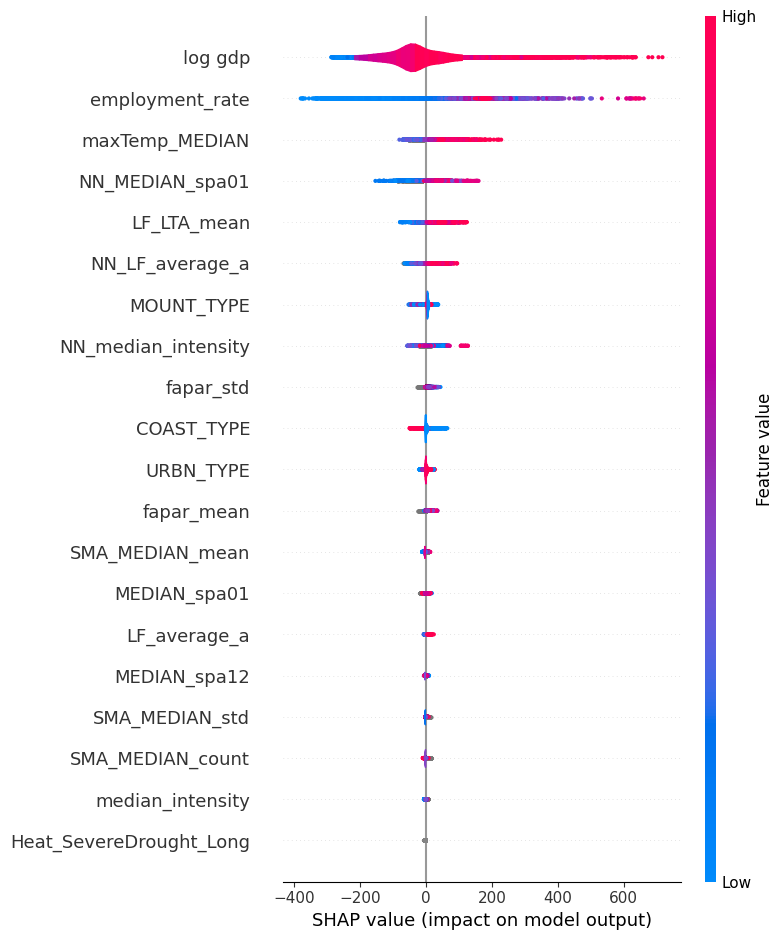

In [21]:
# Assess Feature Importance

# Create a TreeExplainer and calculate shap values
explainer = shap.TreeExplainer(hgb_ag)
shap_values = explainer.shap_values(X_train_ag)

# Plot the shap values
shap.summary_plot(shap_values, X_train_ag, plot_type='violin')

In [22]:
# Get Individual Variable Shap Values

# Print the SHAP values for each feature for the first sample
for i in range(X_train_ag.shape[1]):
    print(f"SHAP value for feature {X_train_ag.columns[i]}: {np.mean(shap_values[i])}")

SHAP value for feature employment_rate: -4.000558631791985
SHAP value for feature LF_average_a: -0.6521113237050606
SHAP value for feature LF_LTA_mean: -2.690768649351192
SHAP value for feature maxTemp_MEDIAN: 1.839697565371308
SHAP value for feature median_intensity: -1.5933077755212612
SHAP value for feature MEDIAN_spa01: -1.8800071530125402
SHAP value for feature MEDIAN_spa12: 1.8196995828999485
SHAP value for feature SMA_MEDIAN_mean: -2.3295079245300236
SHAP value for feature SMA_MEDIAN_std: 0.24874560146916178
SHAP value for feature SMA_MEDIAN_count: -0.2409913655311343
SHAP value for feature HeatWave_Count_Sum: -5.096387543153354
SHAP value for feature Heat_MildDrought_Short: -2.8062116700074213
SHAP value for feature Heat_ModerateDrought_Short: -2.818220892857732
SHAP value for feature Heat_SevereDrought_Short: -2.458444610080935
SHAP value for feature Heat_ExtremeDrought_Short: -0.22692609408725214
SHAP value for feature Heat_MildDrought_Long: -3.238203394866111
SHAP value for 

In [23]:
# Quick Shap Dataset for Feature Analysis

# Create Shap Values Dataset on Average
x_col = []
shap_vals = []

for i in range(X_train_ag.shape[1]):
    x_col.append(X_train_ag.columns[i])
    shap_vals.append(np.mean(shap_values[i]))

shap_val = pd.DataFrame()
shap_val['Feature'] = x_col
shap_val['Shap Value'] = shap_vals
shap_val['Abs Shap Value'] = shap_val['Shap Value'].abs()

# View Largest Shap Value Features by Absolute Value
shap_val.sort_values(by='Abs Shap Value', ascending=False).head(10)

Feature  Shap Value  Abs Shap Value
25                   URBN_TYPE   -5.110867        5.110867
10          HeatWave_Count_Sum   -5.096388        5.096388
0              employment_rate   -4.000559        4.000559
19                   fapar_std   -3.409703        3.409703
15       Heat_MildDrought_Long   -3.238203        3.238203
16   Heat_ModerateDrought_Long   -3.104211        3.104211
12  Heat_ModerateDrought_Short   -2.818221        2.818221
11      Heat_MildDrought_Short   -2.806212        2.806212
2                  LF_LTA_mean   -2.690769        2.690769
27                     log gdp   -2.658842        2.658842

## Industry/Manufacturing Model Explainability

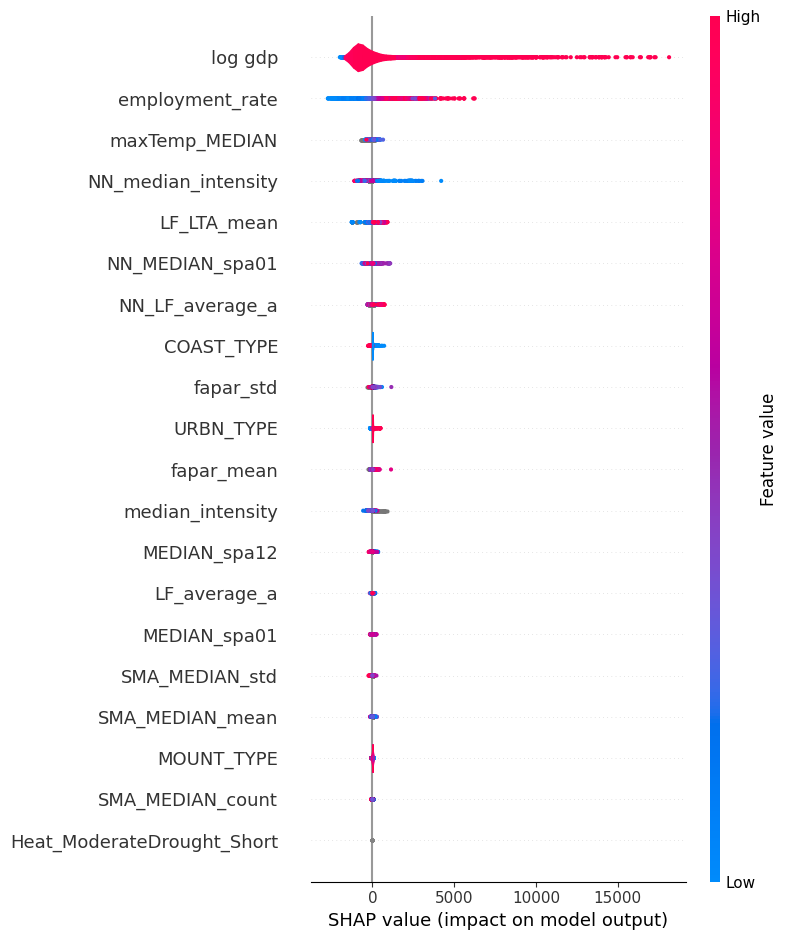

In [24]:
# Assess Feature Importance

# Create a TreeExplainer and calculate shap values
explainer = shap.TreeExplainer(hgb_ind)
shap_values = explainer.shap_values(X_train_ind)

# Plot the shap values
shap.summary_plot(shap_values, X_train_ind, plot_type='violin')

In [25]:
# Get Individual Variable Shap Values

# Print the SHAP values for each feature for the first sample
for i in range(X_train_ind.shape[1]):
    print(f"SHAP value for feature {X_train_ind.columns[i]}: {np.mean(shap_values[i])}")

SHAP value for feature employment_rate: -47.47448077887181
SHAP value for feature LF_average_a: -36.40298238846396
SHAP value for feature LF_LTA_mean: -41.115381927368496
SHAP value for feature maxTemp_MEDIAN: -7.8281002847522405
SHAP value for feature median_intensity: -10.230151460683294
SHAP value for feature MEDIAN_spa01: -23.951472075883466
SHAP value for feature MEDIAN_spa12: -24.740154852792898
SHAP value for feature SMA_MEDIAN_mean: -44.84785823760825
SHAP value for feature SMA_MEDIAN_std: -22.272881459209305
SHAP value for feature SMA_MEDIAN_count: 19.808602829749628
SHAP value for feature HeatWave_Count_Sum: 144.06295222896665
SHAP value for feature Heat_MildDrought_Short: -5.803545631308398
SHAP value for feature Heat_ModerateDrought_Short: -38.02375715724478
SHAP value for feature Heat_SevereDrought_Short: -26.862385918137154
SHAP value for feature Heat_ExtremeDrought_Short: 37.47172748449121
SHAP value for feature Heat_MildDrought_Long: -39.316526653093284
SHAP value for f

In [26]:
# Quick Shap Dataset for Feature Analysis

# Create Shap Values Dataset on Average
x_col = []
shap_vals = []

for i in range(X_train_ind.shape[1]):
    x_col.append(X_train_ind.columns[i])
    shap_vals.append(np.mean(shap_values[i]))

shap_val = pd.DataFrame()
shap_val['Feature'] = x_col
shap_val['Shap Value'] = shap_vals
shap_val['Abs Shap Value'] = shap_val['Shap Value'].abs()

# View Largest Shap Value Features by Absolute Value
shap_val.sort_values(by='Abs Shap Value', ascending=False).head(10)

Feature  Shap Value  Abs Shap Value
10          HeatWave_Count_Sum  144.062952      144.062952
21             NN_MEDIAN_spa01  113.339013      113.339013
25                   URBN_TYPE  -50.280141       50.280141
0              employment_rate  -47.474481       47.474481
7              SMA_MEDIAN_mean  -44.847858       44.847858
2                  LF_LTA_mean  -41.115382       41.115382
15       Heat_MildDrought_Long  -39.316527       39.316527
12  Heat_ModerateDrought_Short  -38.023757       38.023757
14   Heat_ExtremeDrought_Short   37.471727       37.471727
1                 LF_average_a  -36.402982       36.402982